# **02: Training the DROO Agent with Memory-Augmented DNN**

### **Objective**

This notebook marks the core of the DROO project: **training the Deep Reinforcement Learning (DRL) agent**. We will use the `MemoryDNN` agent, which is designed to learn an optimal offloading policy from the data we prepared in the previous notebook.

The goal is to train the agent over a series of time frames, allowing it to learn the complex relationship between wireless channel conditions and the optimal offloading decisions.

### **Notebook Workflow**

1.  **Setup:** Import necessary libraries and define helper functions for plotting and saving results.
2.  **Configuration:** Define the key parameters for our training experiment, such as the number of users and the agent's memory size.
3.  **Data Loading:** Load the pre-processed dataset containing channel gains and the "oracle's" optimal performance rates.
4.  **Model Initialization:** Create an instance of our `MemoryDNN` agent with a specific neural network architecture.
5.  **Training Loop:** Run the main training simulation, where the agent makes decisions, receives feedback (by calculating the computation rate), and updates its internal neural network.
6.  **Performance Analysis:** Visualize the agent's learning progress by plotting its training cost and its performance relative to the oracle.
7.  **Saving Results:** Save the trained model and all relevant performance metrics for future analysis and deployment.

In [2]:
# ===================================================================
# Cell 2: Imports and Environment Setup
# ===================================================================

import os
# This will hide the numerous TensorFlow deprecation warnings for a cleaner output.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# This will hide the Protobuf version mismatch warnings.
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Import the custom agent and optimizer modules
# Make sure agent.py and optimizer.py are in the same directory as this notebook.
from agent import MemoryDNN
from optimizer import bisection

print("Libraries and custom modules imported successfully.")

Libraries and custom modules imported successfully.


In [3]:
# ===================================================================
# Cell 3: Helper Functions
# These functions will be used later for visualizing and saving our results.
# ===================================================================

def plot_rate(rate_his, rolling_intv=50):
    """Plots the rolling average of the computation rate ratio."""
    print("\n--- Plotting Normalized Computation Rate ---")
    rate_array = np.asarray(rate_his)
    df = pd.DataFrame(rate_his)

    try:
        mpl.style.use('seaborn-v0_8-darkgrid')
    except:
        mpl.style.use('seaborn-darkgrid')
        
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the rolling mean
    plt.plot(np.arange(len(rate_array)) + 1,
             np.hstack(df.rolling(rolling_intv, min_periods=1).mean().values), 'b', label='Rolling Mean')
    
    # Add a shaded area for the rolling min/max
    plt.fill_between(np.arange(len(rate_array)) + 1,
                     np.hstack(df.rolling(rolling_intv, min_periods=1).min()[0].values),
                     np.hstack(df.rolling(rolling_intv, min_periods=1).max()[0].values),
                     color='b', alpha=0.2, label='Rolling Min-Max Range')

    plt.ylabel('Normalized Computation Rate (Agent vs. Oracle)')
    plt.xlabel('Time Frames')
    plt.title(f'Agent Performance Over Time (Rolling Window = {rolling_intv})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def save_to_txt(data, file_path):
    """Saves a list of data to a text file."""
    with open(file_path, 'w') as f:
        for item in data:
            if isinstance(item, np.ndarray):
                item_str = ' '.join(map(str, item.flatten()))
                f.write(f"{item_str}\n")
            else:
                f.write(f"{item}\n")

print("Helper functions defined.")

Helper functions defined.


### **Cell 4: Experiment Parameters**

Here, we define all the hyperparameters for our training run. This allows for easy modification and tracking of different experiments.
- **`N`**: The number of wireless users in the system.
- **`n`**: The total number of time frames (simulation steps) to run.
- **`K`**: The initial number of candidate decisions the agent considers at each step.
- **`decoder_mode`**: The method used by the agent to select candidate decisions ('OP' for Optimization Problem based, 'KNN' for K-Nearest Neighbors).
- **`Memory`**: The capacity of the agent's experience replay buffer.
- **`Delta`**: The interval (in time frames) at which the agent adaptively adjusts `K`.

In [4]:
# ===================================================================
# Cell 4: Experiment Parameters
# ===================================================================

# --- System and Simulation Parameters ---
N = 10                  # Number of users
n = 30000               # Number of time frames (simulation steps)

# --- Agent Hyperparameters ---
K = N                   # Initial number of candidate decisions
decoder_mode = 'OP'     # 'OP' or 'KNN'
Memory = 1024           # Memory capacity of the DNN
Delta = 32              # Interval for adaptive K adjustment

print("--- Experiment Configuration ---")
print(f"Number of Users (N): {N}")
print(f"Time Frames (n): {n}")
print(f"Initial Candidates (K): {K}")
print(f"Decoder Mode: {decoder_mode}")
print(f"Memory Size: {Memory}")
print(f"Adaptive K Interval (Delta): {Delta}")
print("--------------------------------")

--- Experiment Configuration ---
Number of Users (N): 10
Time Frames (n): 30000
Initial Candidates (K): 10
Decoder Mode: OP
Memory Size: 1024
Adaptive K Interval (Delta): 32
--------------------------------


### **Cell 5: Data Loading and Preparation**

We load the pre-computed dataset. The channel gains are scaled by `1e6` to bring them into a more suitable range for the neural network, which generally performs better with inputs that are not extremely small. The data is then split into a training set (80%) and a testing set (20%).

In [5]:
# ===================================================================
# Cell 5: Data Loading and Preparation
# ===================================================================

print("--- Loading and Preparing Data ---")
# Load data from the .mat file
data = sio.loadmat(f'./data/data_{N}')
channel = data['input_h'] * 1e6   # Scale channel gains for better NN performance
rate_oracle = data['output_obj']    # This is the optimal "oracle" rate

# Split into training and testing sets (80/20 split)
split_idx = int(0.8 * len(channel))
num_test = len(channel) - split_idx

print(f"Data loaded successfully. Total samples: {len(channel)}")
print(f"Training samples: {split_idx}")
print(f"Testing samples: {num_test}")
print("------------------------------------")

--- Loading and Preparing Data ---
Data loaded successfully. Total samples: 30000
Training samples: 24000
Testing samples: 6000
------------------------------------


### **Cell 6: Agent Initialization**

We create an instance of our `MemoryDNN` agent. The network architecture is defined by the `net` parameter. In this case, it's a fully connected neural network with:
- An input layer of size `N` (one for each user's channel gain).
- Two hidden layers with 120 and 80 neurons, respectively.
- An output layer of size `N` (producing a binary offloading decision for each user).

In [6]:
# ===================================================================
# Cell 6: Agent Initialization
# ===================================================================

# Initialize the MemoryDNN agent with the specified architecture and hyperparameters
mem = MemoryDNN(
    net=[N, 120, 80, N],
    learning_rate=0.01,
    training_interval=10,
    batch_size=128,
    memory_size=Memory
)

print("MemoryDNN agent initialized successfully.")
print(f"Network Architecture: {mem.net}")


MemoryDNN agent initialized successfully.
Network Architecture: [10, 120, 80, 10]


### **Cell 7: The Training Loop**

This is the core of the notebook. We iterate through each time frame, performing the **Agent-Environment interaction loop**:
1.  **Observe State:** Get the current channel conditions (`h`).
2.  **Agent Acts (Decode):** The agent's DNN uses the state `h` to generate `K` potential offloading decisions (`m_list`).
3.  **Environment Responds:** For each potential decision, we use the `bisection` optimizer to calculate the resulting computation rate.
4.  **Select Best Action:** The agent identifies which of the `K` decisions yielded the highest rate.
5.  **Agent Learns (Encode):** The agent stores the state (`h`) and the best corresponding action (`best_mode`) into its memory buffer for future training. The DNN is periodically trained on batches of this stored experience.

In [7]:
# ===================================================================
# Cell 7: The Training Loop
# ===================================================================

# --- Tracking variables for storing results from each time frame ---
rate_his = []
rate_his_ratio = []
mode_his = []
k_idx_his = []
K_his = []

print("--- Starting Training Loop ---")
start_time = time.time()

# --- Main Loop ---
for i in range(n):
    # Print progress at 10% intervals
    if i % (n // 10) == 0:
        print(f"Progress: {i/n:.0%}")

    # Adaptive K adjustment at every 'Delta' interval
    if i > 0 and i % Delta == 0:
        if len(k_idx_his) >= Delta:
            # Find the max index used in the last 'Delta' steps
            max_k_in_window = max(k_idx_his[-Delta:]) + 1
            K = min(max_k_in_window + 1, N)
    
    # Use training data for the first part, then switch to test data
    if i < split_idx:
        i_idx = i
    else:
        # Cycle through the test data
        i_idx = split_idx + (i - split_idx) % num_test

    h = channel[i_idx, :]

    # 1. Agent decodes the state to get candidate actions
    m_list = mem.decode(h, K, decoder_mode)

    # 2. Environment calculates the rate for each candidate action
    r_list = [bisection(h / 1e6, m)[0] for m in m_list]

    # 3. Agent selects the best action from the candidates
    best_idx = np.argmax(r_list)
    best_mode = m_list[best_idx]

    # 4. Agent encodes the state-action pair for learning
    mem.encode(h, best_mode)

    # 5. Save statistics for this time frame
    rate_his.append(r_list[best_idx])
    rate_his_ratio.append(rate_his[-1] / rate_oracle[i_idx][0]) 
    k_idx_his.append(best_idx)
    K_his.append(K)
    mode_his.append(best_mode)

# --- Post-Loop Summary ---
total_time = time.time() - start_time
print("--- Training Loop Finished ---")
print(f"Total time consumed: {total_time:.2f} seconds")
print(f"Average time per time frame: {total_time / n * 1000:.4f} ms")

--- Starting Training Loop ---
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
--- Training Loop Finished ---
Total time consumed: 1742.75 seconds
Average time per time frame: 58.0916 ms


### **Cell 8: Performance Analysis & Visualization**

Now that the agent is trained, we visualize its learning process and final performance.
1.  **Training Cost:** This plot shows the Mean Squared Error (MSE) loss of the neural network during training. A downward trend indicates the network is successfully learning to map states to good actions.
2.  **Normalized Computation Rate:** This plot shows the agent's achieved computation rate as a ratio of the oracle's optimal rate. A value close to 1.0 means the agent is performing almost as well as the perfect, non-real-time optimizer.

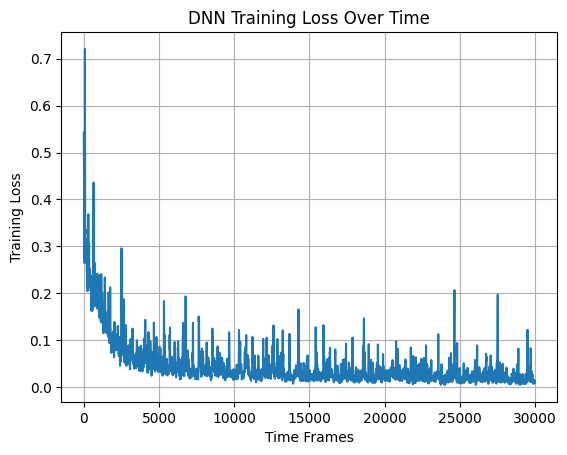


--- Plotting Normalized Computation Rate ---


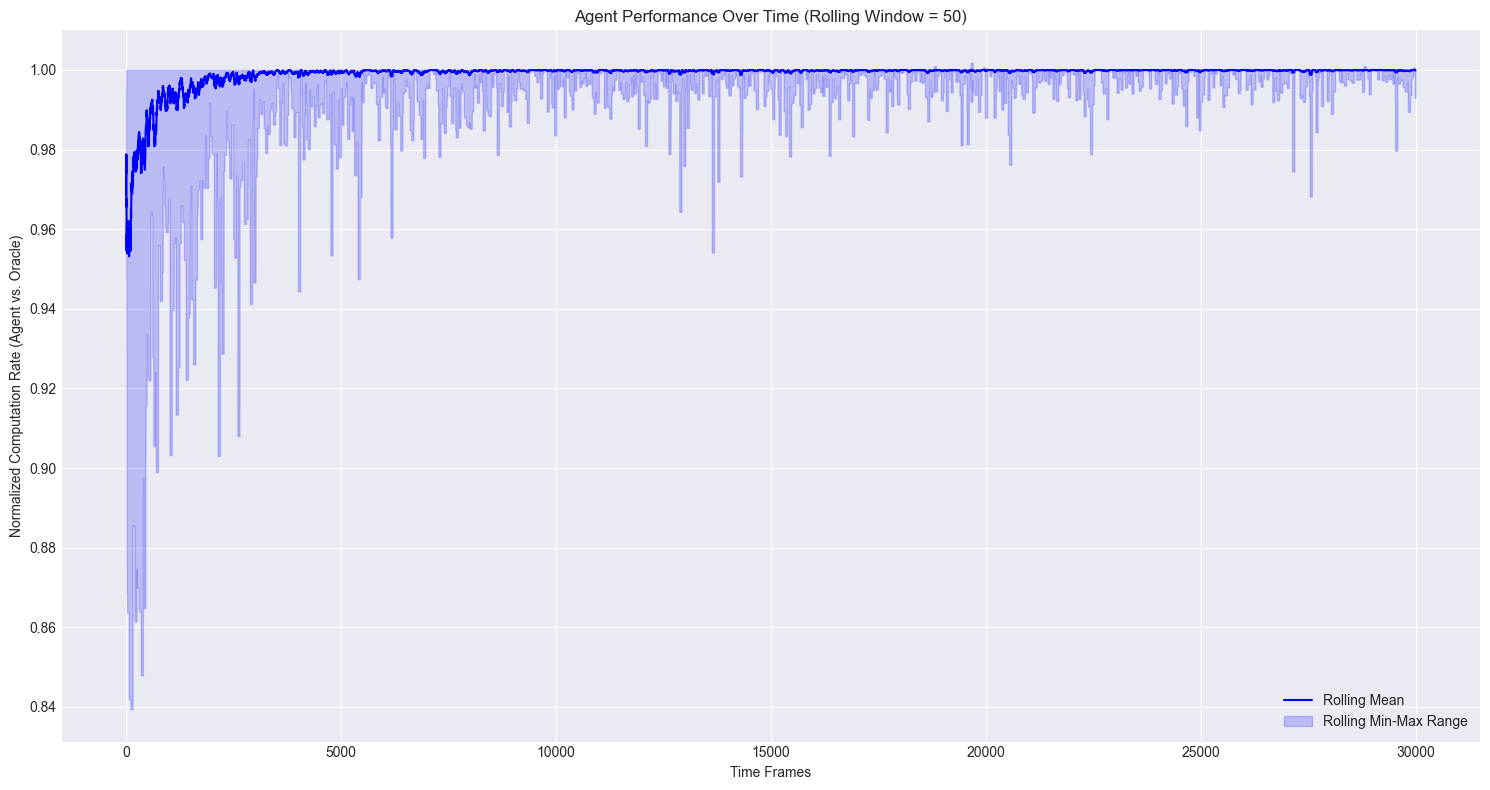

In [8]:
# ===================================================================
# Cell 8: Performance Analysis and Visualization
# ===================================================================

# --- Plot 1: Agent's Training Cost (Loss) ---
mem.plot_cost()

# --- Plot 2: Agent's Normalized Performance Rate ---
plot_rate(rate_his_ratio)

### **Cell 9: Final Performance Metrics**

We calculate the final, averaged performance of our trained agent specifically on the **test set**. This metric is the most important indicator of the agent's ability to generalize to new, unseen channel conditions.

In [9]:
# ===================================================================
# Cell 9: Final Performance Metrics
# ===================================================================

# Ensure num_test is not zero to avoid DivisionByZeroError
if num_test > 0:
    # Average the performance ratio over the last 'num_test' time frames
    avg_rate_test = sum(rate_his_ratio[-num_test:]) / num_test
    print("\n--- Final Performance on Test Set ---")
    print(f"Averaged normalized computation rate: {avg_rate_test:.4f}")
    print(f"(This means the agent achieved {avg_rate_test:.2%} of the oracle's performance on unseen data)")
else:
    print("\nWarning: No test data was processed, cannot calculate final average rate.")


--- Final Performance on Test Set ---
Averaged normalized computation rate: 0.9999
(This means the agent achieved 99.99% of the oracle's performance on unseen data)


### **Cell 10: Saving Model and Training History**

Finally, we save all the important artifacts from our training run.
-   **Trained Model (`.ckpt`):** The weights and biases of the trained neural network are saved so we can load and use the agent later without retraining.
-   **History Files (`.txt`):** All the performance metrics and decisions made during the simulation are saved to text files for more detailed offline analysis.

**Note:** Please ensure you have created a `saved_model` directory in your project folder before running this cell.

In [10]:
# ===================================================================
# Cell 10: Saving Results
# ===================================================================

# --- Create the output directory if it doesn't exist ---
output_dir = "./training_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if not os.path.exists("./saved_model_new"):
    os.makedirs("./saved_model_new")

# --- Save the Trained Model ---
model_path = "./saved_model_new/model.ckpt"
mem.save_model(model_path)
print(f"Trained model saved to: {model_path}")

# --- Save History Data ---
save_to_txt(k_idx_his, os.path.join(output_dir, "k_idx_his.txt"))
save_to_txt(K_his, os.path.join(output_dir, "K_his.txt"))
save_to_txt(mem.cost_his, os.path.join(output_dir, "cost_his.txt"))
save_to_txt(rate_his_ratio, os.path.join(output_dir, "rate_his_ratio.txt"))
save_to_txt(mode_his, os.path.join(output_dir, "mode_his.txt"))

print(f"All history files saved to the '{output_dir}' directory.")

Model saved in path: ./saved_model_new/model.ckpt
Trained model saved to: ./saved_model_new/model.ckpt
All history files saved to the './training_results' directory.
